<a href="https://colab.research.google.com/github/khashayarghamati/PetFinder/blob/colab/PetFinder_my.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
! pip install kaggle
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c petfinder-pawpularity-score
! unzip petfinder-pawpularity-score.zip
! pip install pyyaml h5py
#!mkdir -p /content/drive/MyDrive/saved_model
#!mkdir -p /content/drive/MyDrive/saved_model/histories

Streaming output truncated to the last 5000 lines.
  inflating: train/7e6ca633d2a751af58e1cc220ca519b3.jpg  
  inflating: train/7e717923c22053e51861a24aae701fb0.jpg  
  inflating: train/7e761f47cc1e3038a431f9f196234ab9.jpg  
  inflating: train/7e7921ed945c3c863882340360c9157d.jpg  
  inflating: train/7e8763e28a01c059b7a8d119c5ae0dc0.jpg  
  inflating: train/7e93691bef9bc381590cf004358ee11a.jpg  
  inflating: train/7e947e83394b6d74f1ec4f5b596bed6a.jpg  
  inflating: train/7e9d46bd87849a49ada5f2c336c9d929.jpg  
  inflating: train/7e9df6c36fd06411ce717d0ce761af35.jpg  
  inflating: train/7ea78b0c0bb036b1bbb76b99ec0b731c.jpg  
  inflating: train/7ead412443b3b7f598c53fbf9335caac.jpg  
  inflating: train/7ebc00bdcf3101c2f270c309fee0e8db.jpg  
  inflating: train/7ec3ce65d3cd31e2f94b5631b7b36269.jpg  
  inflating: train/7ed7fcecc7525b46ea035053ffdbb8d1.jpg  
  inflating: train/7edbf87e8f86e5f7d5ff516fb22cc6cc.jpg  
  inflating: train/7ede49445a993940ca73f80e30b72f62.jpg  
  inflating: train/7e

In [23]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import numpy as np

In [24]:
train_metadata = pd.read_csv('train.csv')
test_metadata = pd.read_csv('test.csv')

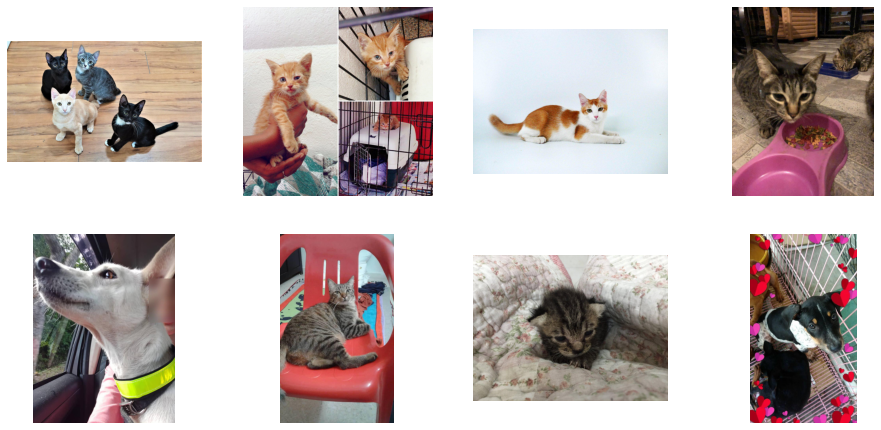

In [25]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
train_images_fnames = os.listdir('train')

pic_index+=8

next_image_pix = [os.path.join('train', fname) 
                for fname in train_images_fnames[ pic_index-8:pic_index] 
               ]

for i, img_path in enumerate(next_image_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [26]:
def add_image_format(item):
  return f"{item}.jpg"

train_image_names = list(train_metadata['Id'].apply(add_image_format))
test_image_names = list(test_metadata['Id'].apply(add_image_format))

In [27]:
train_metadata['filename'] = train_image_names
test_metadata['filename'] = test_image_names
X = train_metadata.drop(['Id'], axis=1) 
y = train_metadata['Pawpularity']
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.1, random_state=42)


number_of_items_in_batch = 50
total_batch_data_size = 20

data_X_train_batches = X_train#[X_train[i:i + number_of_items_in_batch] for i in range(0, len(X_train), total_batch_data_size)]
data_y_train_batches = y_train#[y_train[i:i + number_of_items_in_batch] for i in range(0, len(y_train), total_batch_data_size)]
data_X_dev_batches = X_dev#[X_dev[i:i + number_of_items_in_batch] for i in range(0, len(X_dev), total_batch_data_size)]
data_y_dev_batches = y_dev#[y_dev[i:i + number_of_items_in_batch] for i in range(0, len(y_dev), total_batch_data_size)]

X_test_data = test_metadata.drop(['Id'], axis=1)

In [28]:
import cv2
class DataLoader:
  def prepare(self, batch_data_index=0, path='train'):
    self.batch_data_index = batch_data_index
    self.make_data(path)

  def get_images(self, data, path):
    npz_paths = []
    if type(self.batch_data_index) == str:
      _data_in_loop = data[:]['filename'] if path == 'train' else data['filename']
    else:
      _data_in_loop = data[self.batch_data_index]['filename'] if path == 'train' else data['filename']
    for i in _data_in_loop:
      pic_bgr_arr = cv2.imread(f'{path}/{i}')
      resized = cv2.resize(pic_bgr_arr, (100, 100), interpolation = cv2.INTER_AREA)
      pic_rgb_arr = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
      
      npz_file_name = f"{i.split('.')[0]}.npz"
      npz_paths.append(npz_file_name)
      np.savez_compressed(npz_file_name, pic=pic_rgb_arr/255)
    return npz_paths
  
  def get_X_y(self, df, is_test=False):
    X_pic, X_stats = [], []
    y = []

    for index, record in df.iterrows():
      loaded_npz = np.load(record['NPZ_Path'])

      pic = loaded_npz['pic']
      X_pic.append(pic)

      if not is_test:
        stats = record.drop(['Pawpularity', 'filename', 'NPZ_Path'])
        X_stats.append(stats)
        y.append(record['Pawpularity'])
      else:
        stats = record.drop(['filename', 'NPZ_Path'])
        X_stats.append(stats)


    X_pic, X_stats = np.array(X_pic), np.array(X_stats)
    if not is_test:
      y = np.array(y)
      return (X_pic, X_stats), y
    else:
      return (X_pic, X_stats)

  def make_data(self, path):
    if path == 'test':
      NPZ_Pathes = self.get_images(X_test_data, path)
      X_test_data['NPZ_Path'] = NPZ_Pathes
      (self.test_images, self.test_meta) = self.get_X_y(X_test_data, True)
    else:
      trained_data = self.get_images(data_X_train_batches, path)
      deved_data = self.get_images(data_X_dev_batches, path)
      
      if type(self.batch_data_index) == str:
        data_X_train_batches['NPZ_Path'] = trained_data
        data_X_dev_batches['NPZ_Path'] = deved_data  
        (self.train_images, self.train_meta), self.y_train = self.get_X_y(data_X_train_batches)
        (self.dev_images, self.dev_meta), self.y_dev = self.get_X_y(data_X_train_batches)
      else:
        data_X_train_batches[self.batch_data_index]['NPZ_Path'] = trained_data
        data_X_dev_batches[self.batch_data_index]['NPZ_Path'] = deved_data
        (self.train_images, self.train_meta), self.y_train = self.get_X_y(data_X_train_batches[self.batch_data_index])
        (self.dev_images, self.dev_meta), self.y_dev = self.get_X_y(data_X_train_batches[self.batch_data_index])

      

  def get_dev_data(self):
    return (np.asarray(self.dev_images).astype('float32'), np.asarray(self.dev_meta).astype('float32')), np.asarray(self.y_dev).astype('float32')

  def get_train_data(self):
    return (np.asarray(self.train_images).astype('float32'), np.asarray(self.train_meta).astype('float32')), np.asarray(self.y_train).astype('float32')
  
  def get_test_data(self):
    return (np.asarray(self.test_images).astype('float32'), np.asarray(self.test_meta).astype('float32'))


In [29]:
data = DataLoader()
data.prepare(path='test')
(test_images, test_meta) = data.get_test_data()
test_images.shape, test_meta.shape


((8, 100, 100, 3), (8, 12))

# Create a network for metadata

In [30]:
input_meta = tf.keras.layers.Input(shape=(12,))
meta_d = tf.keras.layers.Dense(50, activation='relu')(input_meta)
meta_d = tf.keras.layers.Dense(20, activation='relu')(meta_d)
meta_d = tf.keras.layers.Dense(12, activation='relu')(meta_d)
meta_model = tf.keras.Model(inputs=input_meta, outputs=meta_d)

## Create CNN

In [31]:
def identity_block(X, f, filters, training=True, initializer=random_uniform):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (m, n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)
    
    ### START CODE HERE
    ## Second component of main path (≈3 lines)
    ## Set the padding = 'same'
    X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X) 

    ## Third component of main path (≈2 lines)
    ## Set the padding = 'valid'
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) 
    
    ## Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X) 
    ### END CODE HERE

    return X

In [32]:
def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    
    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    ### START CODE HERE
    
    ## Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1), padding='same', kernel_initializer = initializer(seed=0))(X) 
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X) 

    ## Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1, 1), padding='valid', kernel_initializer = initializer(seed=0))(X)  
    X = BatchNormalization(axis = 3)(X, training=training) 
    
    ##### SHORTCUT PATH ##### (≈2 lines)
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X_shortcut)  
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training=training)
    
    ### END CODE HERE

    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [33]:
def ResNet50(input_shape = (100, 100, 3), classes = 6):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Normalizing data
    #X_input = tf.keras.layers.Rescaling(1./255)(X_input)
    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(224, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [200, 200, 256], s = 1)
    X = identity_block(X, 3, [200, 200, 256])
    X = identity_block(X, 3, [200, 200, 256])

    ### START CODE HERE
    
    ## Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128,128,512], s = 2) 
    X = identity_block(X, 3, [128,128,512]) 
    X = identity_block(X, 3, [128,128,512]) 
    X = identity_block(X, 3, [128,128,512]) 
    
    ## Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2) 
    X = identity_block(X, 3, [256, 256, 1024]) 
    X = identity_block(X, 3, [256, 256, 1024]) 
    X = identity_block(X, 3, [256, 256, 1024]) 
    X = identity_block(X, 3, [256, 256, 1024]) 
    X = identity_block(X, 3, [256, 256, 1024]) 

    ## Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)  
    X = identity_block(X, 3, [512, 512, 2048])  
    X = identity_block(X, 3, [512, 512, 2048]) 

    ## AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size=(2, 2))(X)
    
    ### END CODE HERE

    # output layer
    X = Flatten()(X)
    # X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [34]:
cnn_model = ResNet50(input_shape = (100, 100, 3), classes = 1)

In [35]:
combined = tf.keras.layers.concatenate([cnn_model.output, meta_model.output])

In [36]:
X = Dense(len(train_image_names)+12, activation='relu')(combined)
X = Dense(50, activation='relu')(X)
X = Dense(10, activation='relu')(X)
X = Dense(1, activation='linear')(X)
final_model = Model(inputs=[cnn_model.input, meta_model.input], outputs=X)

In [37]:
final_model.compile(optimizer='adam', loss='mse',
    metrics=['mean_absolute_error'])

In [38]:
#tf.keras.utils.plot_model(final_model, show_shapes=True, show_layer_names=False)

In [39]:
#final_model.summary()

In [40]:
histories = []
data = DataLoader()
start_batch = 0
end_batch = 20
is_new_trained = save_model = False
total_batch_data_size = 1
for batch_data_index in range(total_batch_data_size):#[start_batch:end_batch]:
    if is_new_trained:
        final_model = tf.keras.models.load_model(f'/content/drive/MyDrive/saved_model/final_model_{end_batch}')
        is_new_trained = False
    print(f'----------------Iterate_{batch_data_index}---------------')
    data.prepare(batch_data_index='all')

    (train_images, train_meta), y_train = data.get_train_data()
    (dev_images, dev_meta), y_dev = data.get_dev_data()
    
#     checkpoint_filepath = '/kaggle/working/checkpoint'
#     model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     save_weights_only=True,
#     monitor='val_mean_absolute_error',
#     mode='max',
#     save_best_only=True)

    
    histories.append(final_model.fit(x=[train_images, train_meta], y=y_train, validation_data=([dev_images, dev_meta], y_dev), verbose=1, epochs=190))
    if save_model:
        final_model.save(f'/content/drive/MyDrive/saved_model/final_model_{end_batch}')

----------------Iterate_0---------------
Epoch 1/190
279/279 [==============================] - 67s 177ms/step - loss: 469.9890 - mean_absolute_error: 16.1807 - val_loss: 425.8742 - val_mean_absolute_error: 15.0356
Epoch 2/190
279/279 [==============================] - 55s 198ms/step - loss: 432.9184 - mean_absolute_error: 15.5528 - val_loss: 423.1652 - val_mean_absolute_error: 15.2273
Epoch 3/190
279/279 [==============================] - 56s 200ms/step - loss: 436.5914 - mean_absolute_error: 15.6077 - val_loss: 436.0020 - val_mean_absolute_error: 16.5471
Epoch 4/190
279/279 [==============================] - 47s 168ms/step - loss: 431.8635 - mean_absolute_error: 15.5296 - val_loss: 431.2253 - val_mean_absolute_error: 14.7951
Epoch 5/190
279/279 [==============================] - 49s 174ms/step - loss: 434.3669 - mean_absolute_error: 15.5971 - val_loss: 421.8720 - val_mean_absolute_error: 15.6101
Epoch 6/190
279/279 [==============================] - 47s 168ms/step - loss: 428.4253 - 

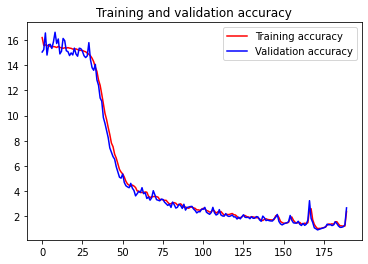

<Figure size 432x288 with 0 Axes>

In [42]:
acc = []
val_acc = []
loss = []
val_loss = []

for history in histories: 
  acc += history.history['mean_absolute_error']
  val_acc += history.history['val_mean_absolute_error']
  loss += history.history['loss']
  val_loss += history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

In [43]:
import json
path = '/content/drive/MyDrive/saved_model/histories/h.txt'
# if os.path.exists(path):
#   histories = json.load(open(path, 'r'))
# else:
histories = [i.history for i in histories]
json.dump(histories, open(path, 'w'))


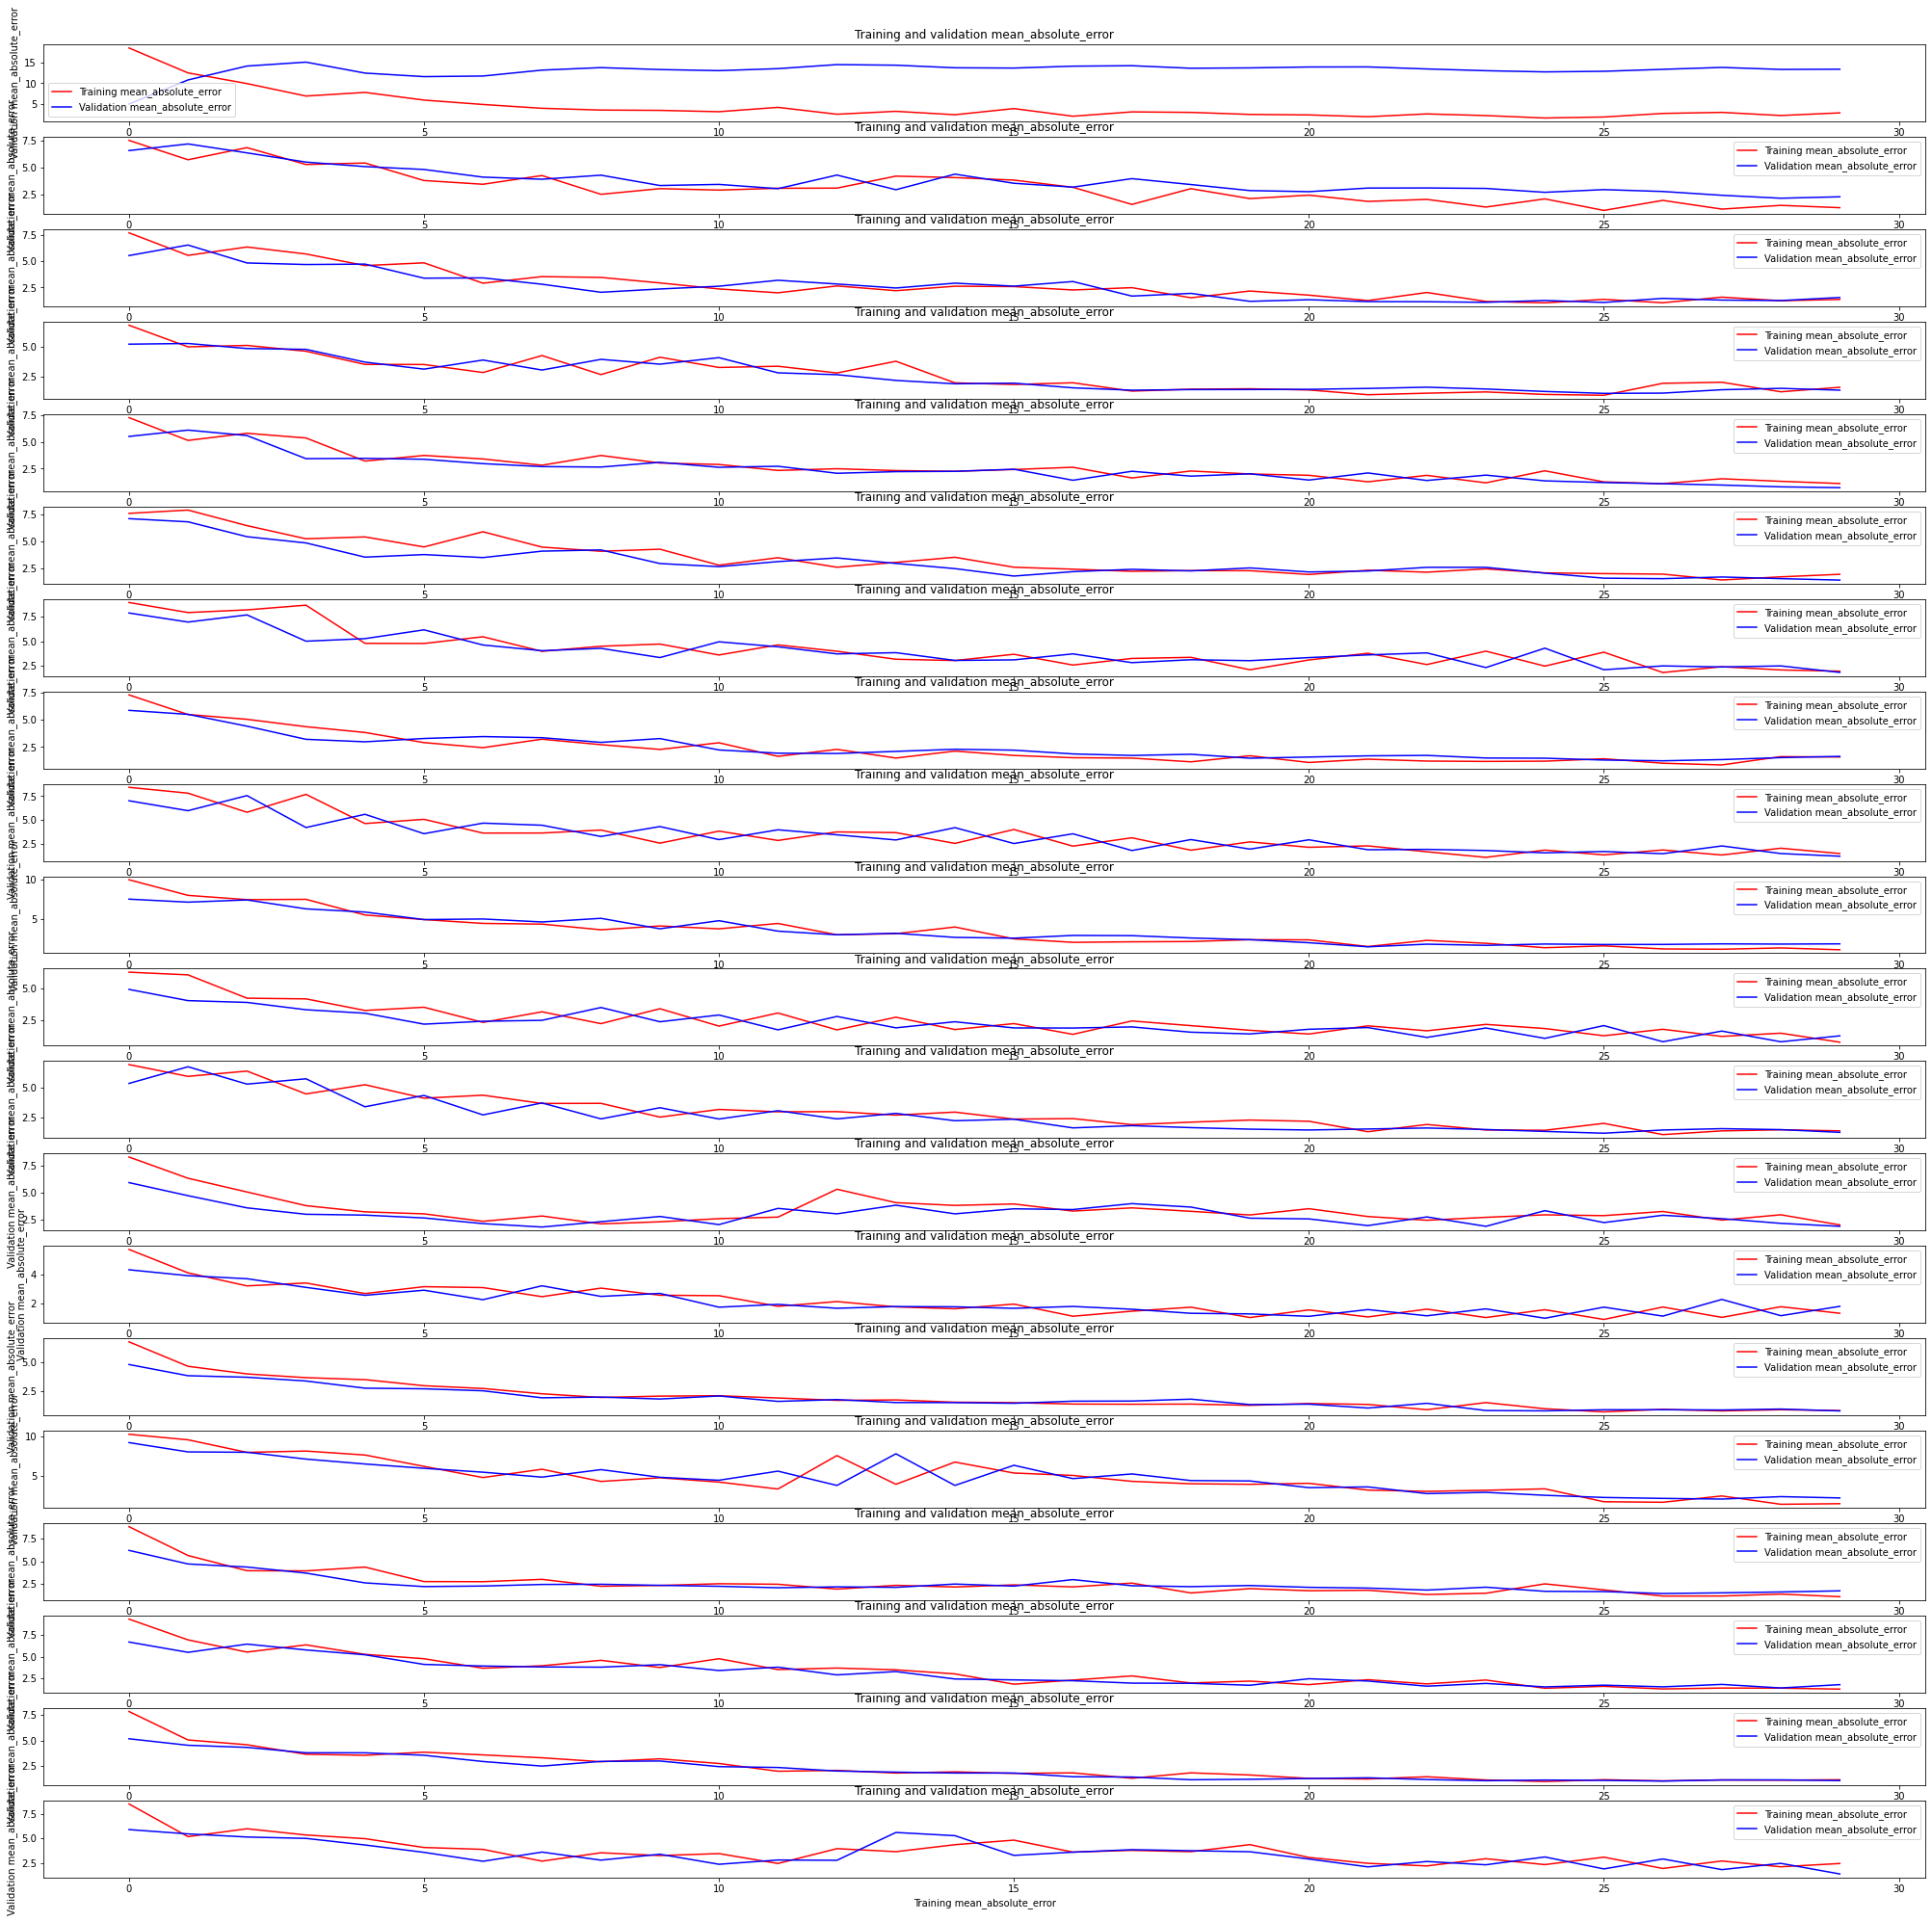

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=len(histories), ncols=1, figsize=(35,35))

plt.legend(loc=0)
for i, ax in enumerate(axes.flatten()):
  history = histories[i]
  acc = history['mean_absolute_error']
  val_acc = history['val_mean_absolute_error']
  loss = history['loss']
  val_loss = history['val_loss']

  epochs = range(len(acc))

  ax.plot(epochs, acc, 'r', label='Training mean_absolute_error')
  ax.plot(epochs, val_acc, 'b', label='Validation mean_absolute_error')
  ax.set_title('Training and validation mean_absolute_error')
  ax.set_xlabel('Training mean_absolute_error')
  ax.set_ylabel('Validation mean_absolute_error')
  ax.legend()

plt.show()

In [45]:
test_predictions = final_model.predict([test_images, test_meta]).flatten()
test_predictions.shape

(8,)

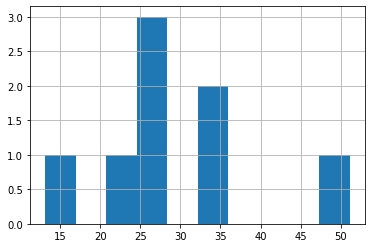

In [46]:
test_preds_series = pd.Series(test_predictions, name='Pawpularity')

test_preds_series.hist()

In [47]:
test_preds_df = test_preds_series.to_frame()
test_preds_df.head()

,Pawpularity
0,33.828770
1,13.175909
2,21.199957
3,27.126518
4,24.877085


In [41]:
final_model.save(f'/content/drive/MyDrive/saved_model/final_model_1')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/saved_model/final_model_1/assets
